In [1]:
! [ -e /content ] && pip install -Uqq fastai 

     |████████████████████████████████| 194kB 8.9MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 


In [2]:
from fastai.vision.all import *

# Multi label classification

In [ ]:
#import data
path = untar_data(URLs.PASCAL_2007)


In [ ]:
Path.BASE_PATH = path
path.ls() 

(#8) [Path('valid.json'),Path('train.csv'),Path('train.json'),Path('segmentation'),Path('test.csv'),Path('train'),Path('test'),Path('test.json')]

In [ ]:
Path(path/"train").ls()

(#5012) [Path('train/008101.jpg'),Path('train/002439.jpg'),Path('train/002957.jpg'),Path('train/005173.jpg'),Path('train/003772.jpg'),Path('train/009778.jpg'),Path('train/003941.jpg'),Path('train/001346.jpg'),Path('train/008931.jpg'),Path('train/005068.jpg')...]

In [ ]:
#labels are available in csv format
df = pd.read_csv(path/"train.csv")
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### Pandas summary

Pandas is a Python library that is used to manipulate and analyze tabular and time series data. The main class is DataFrame, which represents a table of rows and columns. You can get a DataFrame from a CSV file, a database table, Python dictionaries, and many other sources.

In [ ]:
#access rows and columns of a DataFrame with the iloc property
df.iloc[0,:]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [ ]:
#grab a column by name by indexing into a DataFrame 
df['labels']

0                chair
1                  car
2         horse person
3                  car
4              bicycle
             ...      
5006      horse person
5007              boat
5008    person bicycle
5009               car
5010               dog
Name: labels, Length: 5011, dtype: object

In [ ]:
#create new columns
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [ ]:
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


### Constructing a DataBlock

PyTorch and fastai have two main classes for representing and accessing a training set or validation set:

- `Dataset`:: A collection that returns a tuple of your independent and dependent variable for a single item
- `DataLoader`:: An iterator that provides a stream of mini-batches, where each mini-batch is a tuple of a batch of independent variables and a batch of dependent variables

On top of these, fastai provides two classes for bringing your training and validation sets together:

- `Datasets`:: An object that contains a training `Dataset` and a validation `Dataset`
- `DataLoaders`:: An object that contains a training `DataLoader` and a validation `DataLoader`

In [ ]:
#create datablock with no parameters
dblock = DataBlock()

#Create a dataset object with this and add the source
dsets = dblock.datasets(df)

In [ ]:
#dsets contains training and validation data
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [ ]:
#get one data
x,y = dsets.train[0]
x

fname       009410.jpg
labels          person
is_valid         False
Name: 4721, dtype: object

In [ ]:
y

fname       009410.jpg
labels          person
is_valid         False
Name: 4721, dtype: object

by default, the data block assumes we have two things: input and target. We are going to need to grab the appropriate fields from the DataFrame, which we can do by passing get_x and get_y functions

In [ ]:
x['fname']

'009410.jpg'

In [ ]:
a = lambda r: r['fname']
a(x)

'009410.jpg'

In [ ]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('002375.jpg', 'cat')

To actually open the image and do the conversion to tensors, we will need to use a set of transforms; block types will provide us with those. We can use the same block types that we have used previously, with one exception: the `ImageBlock` will work fine again, because we have a path that points to a valid image, but the `CategoryBlock` is not going to work. The problem is that block returns a single integer, but we need to be able to have multiple labels for each item. To solve this, we use a `MultiCategoryBlock`. This type of block expects to receive a list of strings, as we have in this case

In [ ]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [ ]:
#get labels for one hot encoding
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['bird']

In [ ]:
torch.where(dsets.train[0][1]==1.)

(tensor([2]),)

In [ ]:
dsets.train.vocab[6]

'car'

We have ignored the column `is_valid` up until now, which means that `DataBlock` has been using a random split by default. To explicitly choose the elements of our validation set, we need to write a function and pass it to `splitter` (or use one of fastai's predefined functions or classes). It will take the items (here our whole DataFrame) and must return two (or more) lists of integers

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

In [ ]:
print([df.iloc[:5,]['is_valid']])
print(~df.iloc[0]['is_valid'])

[0     True
1     True
2     True
3    False
4     True
Name: is_valid, dtype: bool]
False


In [ ]:
print(df.iloc[:5,].index[df.iloc[:5,]['is_valid']])

Int64Index([0, 1, 2, 4], dtype='int64')


In [ ]:
print(df.iloc[:5,].index[df.iloc[:5,]['is_valid']].tolist())

[0, 1, 2, 4]


In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [ ]:
#to ensure that every item is of the same size can use RandomResizedCrop
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

In [ ]:
b= dls.train.one_batch()
len(b)

2

In [ ]:
len(b[0])

64

In [ ]:
b[1][:2,]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.]])

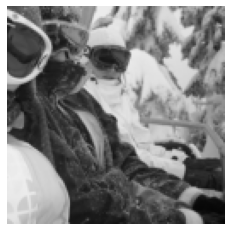

In [ ]:
show_image(b[0][0])

In [ ]:
b[0][0].shape

torch.Size([3, 128, 128])

In [ ]:
idx = torch.where(b[1][0]==1.)[0]
idx

tensor([14])

In [ ]:
dls.train.vocab

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [ ]:
dls.train.vocab[idx]

(#1) ['person']

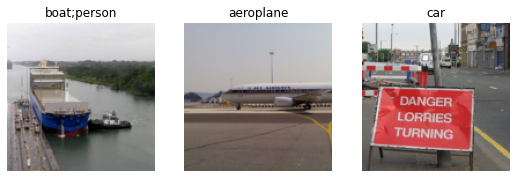

In [ ]:
dls.show_batch(nrows=1, ncols=3)

## Binary Cross-Entropy

We already have our DataLoaders, we can leverage fastai's resnet models (which we'll learn how to create from scratch later), and we know how to create an SGD optimizer. So let's focus on ensuring we have a suitable loss function. To do this, let's use cnn_learner to create a Learner, so we can look at its activations

In [ ]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [ ]:
 #batch size of 64, and we need to calculate the probability of each of 20 categories.
 activs[0]

tensor([-0.5027,  0.5826,  3.2953,  0.8003,  0.7607,  1.5012,  1.4368,  1.4216,
        -1.8670, -0.1892,  0.7914,  0.8622, -1.9079, -0.4490, -0.6766,  0.4336,
        -0.4004,  2.6409,  1.2584,  0.8885], grad_fn=<SelectBackward>)

In [ ]:
activs[0].sum()

tensor(10.6806, grad_fn=<SumBackward0>)

> note: Getting Model Activations: Knowing how to manually get a mini-batch and pass it into a model, and look at the activations and loss, is really important for debugging your model. It is also very helpful for learning, so that you can see exactly what is going on.

In [ ]:
#scale values between 0 and 1
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

Note that because we have a one-hot-encoded dependent variable, we can't directly use `nll_loss` or `softmax` (and therefore we can't use `cross_entropy`):

- `softmax`, as we saw, requires that all predictions sum to 1, and tends to push one activation to be much larger than the others (due to the use of `exp`); however, we may well have multiple objects that we're confident appear in an image, so restricting the maximum sum of activations to 1 is not a good idea. By the same reasoning, we may want the sum to be *less* than 1, if we don't think *any* of the categories appear in an image.
- `nll_loss`, as we saw, returns the value of just one activation: the single activation corresponding with the single label for an item. This doesn't make sense when we have multiple labels.


PyTorch already provides this function for us. In fact, it provides a number of versions, with rather confusing names!

`F.binary_cross_entropy` and its module equivalent `nn.BCELoss` calculate cross-entropy on a one-hot-encoded target, but do not include the initial `sigmoid`. Normally for one-hot-encoded targets you'll want `F.binary_cross_entropy_with_logits` (or `nn.BCEWithLogitsLoss`), which do both sigmoid and binary cross-entropy in a single function, as in the preceding example.

The equivalent for single-label datasets (like MNIST or the Pet dataset), where the target is encoded as a single integer, is `F.nll_loss` or `nn.NLLLoss` for the version without the initial softmax, and `F.cross_entropy` or `nn.CrossEntropyLoss` for the version with the initial softmax.

Since we have a one-hot-encoded target, we will use `BCEWithLogitsLoss`

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

tensor(1.0362, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

We don't actually need to tell fastai to use this loss function (although we can if we want) since it will be automatically chosen for us. fastai knows that the `DataLoaders` has multiple category labels, so it will use `nn.BCEWithLogitsLoss` by default.

One change compared to the last chapter is the metric we use: because this is a multilabel problem, we can't use the accuracy function. Why is that? Well, accuracy was comparing our outputs to our targets like so:

```python
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()
```

The class predicted was the one with the highest activation (this is what `argmax` does). Here it doesn't work because we could have more than one prediction on a single image. After applying the sigmoid to our activations (to make them between 0 and 1), we need to decide which ones are 0s and which ones are 1s by picking a *threshold*. Each value above the threshold will be considered as a 1, and each value lower than the threshold will be considered a 0:

```python
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()
```

there is a function in Python called partial. It allows us to bind a function with some arguments or keyword arguments, making a new version of that function that, whenever it is called

In [ ]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [ ]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.939313,0.698650,0.236713,00:27
1,0.821623,0.560943,0.297092,00:27
2,0.598956,0.202749,0.820976,00:27
3,0.360624,0.126620,0.939402,00:27


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133935,0.115981,0.949622,00:28
1,0.117663,0.107424,0.950897,00:28
2,0.099231,0.103436,0.953347,00:28


In [ ]:
preds,targs = learn.get_preds()

In [ ]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9569)

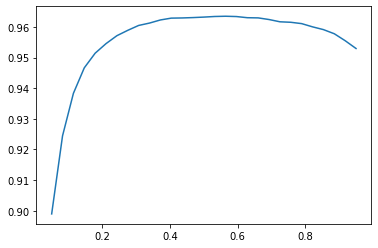

In [ ]:
# to find best threshold
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

# Regression

In [4]:
path = untar_data(URLs.BIWI_HEAD_POSE)
Path.BASE_PATH = path

In [6]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [9]:
((path/"01").ls()).sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [10]:
#get pose file
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('22/frame_00005_pose.txt')

In [11]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

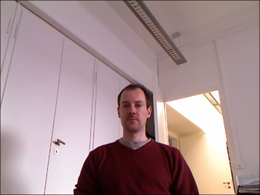

In [13]:
im.to_thumb(260)

In [20]:
np.genfromtxt(img2pose(path/'22'/'frame_00005_ose.txt'))

array([[ 9.93800e-01,  1.50684e-02,  1.10153e-01],
       [-3.91783e-02,  9.74682e-01,  2.20135e-01],
       [-1.04047e-01, -2.23086e-01,  9.69230e-01],
       [ 4.99881e+01,  4.71549e+01,  1.03291e+03]])

In [21]:
np.genfromtxt(img2pose(path/'22'/'frame_00005_ose.txt'), skip_header=3)

array([  49.9881,   47.1549, 1032.91  ])

In [27]:
np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [25]:
#extract the head center point
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [26]:
get_ctr(img_files[0])

tensor([345.0533, 264.1333])

In [28]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

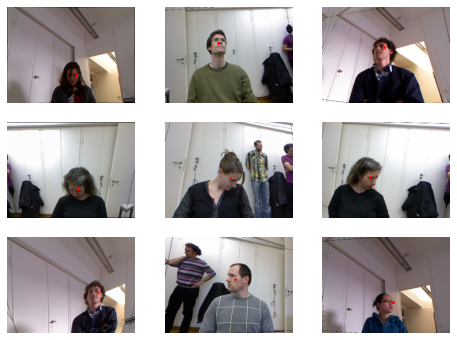

In [29]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [30]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [32]:
yb[0]

tensor([[-0.1292,  0.0566]], device='cuda:0')

## create a model

In [33]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
#y_range is implemented in fastai using sigmoid_range
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

In [34]:
dls.loss_func

FlattenedLoss of MSELoss()

This makes sense, since when coordinates are used as the dependent variable, most of the time we're likely to be trying to predict something as close as possible; that's basically what `MSELoss` (mean squared error loss) does. If you want to use a different loss function, you can pass it to `cnn_learner` using the `loss_func` parameter.

Note also that we didn't specify any metrics. That's because the MSE is already a useful metric for this task (although it's probably more interpretable after we take the square root). 


SuggestedLRs(lr_min=0.004786301031708717, lr_steep=6.309573450380412e-07)

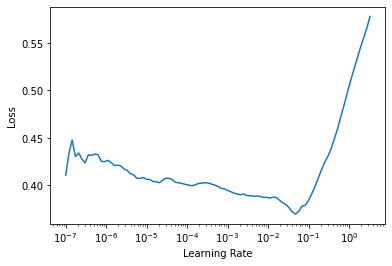

In [36]:
learn.lr_find()

In [37]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.049692,0.007454,02:02


epoch,train_loss,valid_loss,time
0,0.008242,0.001375,02:05
1,0.003212,0.000332,02:03
2,0.001465,0.000068,02:02


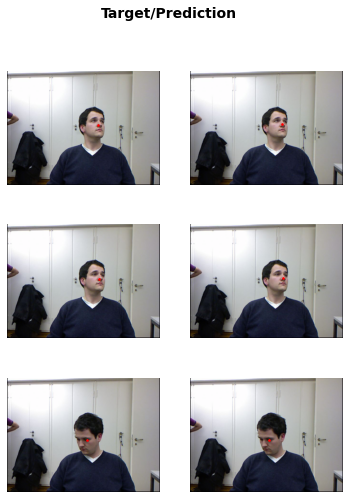

In [38]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))


- `nn.CrossEntropyLoss` for single-label classification
- `nn.BCEWithLogitsLoss` for multi-label classification
- `nn.MSELoss` for regression